In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

2023-04-25 17:33:13.441598: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 17:33:13.795214: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 17:33:14.908032: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df=pd.read_csv(os.path.join('Dataset','train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
from tensorflow.keras.layers import TextVectorization

In [5]:
x=df['comment_text']
y=df[df.columns[2:]].values

In [6]:
y.shape

(159571, 6)

In [7]:
MAX_FEATURES=200000 #number of words in a vocab

In [8]:
vectorizer=TextVectorization(max_tokens=MAX_FEATURES,
                             output_sequence_length=1800,
                             output_mode='int')

2023-04-25 17:33:27.992124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 17:33:28.139047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-25 17:33:28.139274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [9]:
vectorizer.adapt(x.values)

In [10]:
vectorized_text=vectorizer(x.values)

In [11]:
#Data pipeline
dataset=tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset=dataset.cache()
dataset=dataset.shuffle(160000)
dataset=dataset.batch(16)
dataset=dataset.prefetch(8)

In [22]:
train=dataset.take(int(len(dataset)*0.7))
val=dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test=dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,Dropout,Dense,Embedding

In [26]:
model=Sequential()
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(6,activation='sigmoid'))
          

2023-04-16 09:03:27.857571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-16 09:03:27.858726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-16 09:03:27.859966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [27]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [29]:
history=model.fit(train,epochs=10,validation_data=val)

Epoch 1/10


2023-04-16 09:06:53.274573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [159571,6]
	 [[{{node Placeholder/_1}}]]
2023-04-16 09:06:53.275007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [159571,1800]
	 [[{{node Placeholder/_0}}]]
2023-04-16 09:06:55.571620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/sp

6981/6981 [==============================] - ETA: 0s - loss: 0.0624

2023-04-16 09:24:48.139915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [159571,1800]
	 [[{{node Placeholder/_0}}]]
2023-04-16 09:24:48.143252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [159571,6]
	 [[{{node Placeholder/_1}}]]
2023-04-16 09:24:52.571939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/sp

6981/6981 [==============================] - 1213s 172ms/step - loss: 0.0624 - val_loss: 0.0457
Epoch 2/10
6981/6981 [==============================] - 1076s 154ms/step - loss: 0.0460 - val_loss: 0.0489
Epoch 3/10
6981/6981 [==============================] - 1066s 153ms/step - loss: 0.0403 - val_loss: 0.0356
Epoch 4/10
6981/6981 [==============================] - 1068s 153ms/step - loss: 0.0356 - val_loss: 0.0311
Epoch 5/10
6981/6981 [==============================] - 1061s 152ms/step - loss: 0.0323 - val_loss: 0.0290
Epoch 6/10
6981/6981 [==============================] - 1061s 152ms/step - loss: 0.0290 - val_loss: 0.0243
Epoch 7/10
6981/6981 [==============================] - 1059s 152ms/step - loss: 0.0257 - val_loss: 0.0214
Epoch 8/10
6981/6981 [==============================] - 1107s 159ms/step - loss: 0.0232 - val_loss: 0.0218
Epoch 9/10
6981/6981 [==============================] - 1321s 189ms/step - loss: 0.0205 - val_loss: 0.0168
Epoch 10/10
6981/6981 [=========================

In [48]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

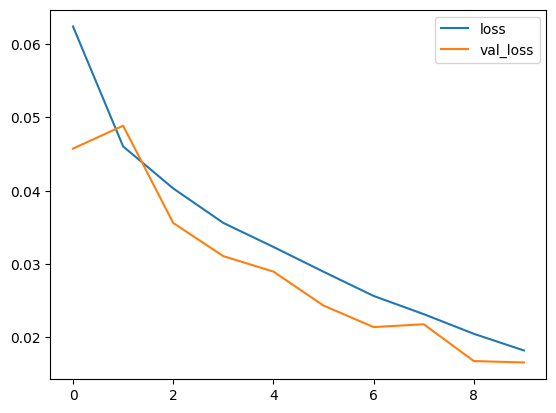

1/1 [==============================] - 0s 67ms/step


In [49]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [30]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [31]:
pre=Precision()
re=Recall()
acc=CategoricalAccuracy()

In [33]:
for batch in test.as_numpy_iterator():
    x_true,y_true=batch
    yhat=model.predict(x_true)
    y_true=y_true.flatten()
    yhat=yhat.flatten()
    pre.update_state(y_true,yhat)
    re.update_state(y_true,yhat)
    acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 87ms/step


In [36]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9131333827972412, Recall: 0.9348861575126648, Accuracy: 0.5065195560455322


In [12]:
import tensorflow as tf
import gradio as gr

In [38]:
model.save('toxic_detector.h5')

In [13]:
model=tf.keras.models.load_model('toxic_detector.h5')

2023-04-25 17:34:07.821507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 17:34:07.823953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 17:34:07.825497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
def score_comment(comment):
    vectorized=vectorizer([comment])
    results=model.predict(vectorized)
    
    text=''
    for idx,col in enumerate(df.columns[2:]):
        text+='{}: {}\n'.format(col,results[0][idx]>0.5)
    return text

In [15]:
interface=gr.Interface(fn=score_comment,
                       inputs=gr.inputs.Textbox(lines=4,placeholder='comment here'),
                       outputs='text')

/home/konerony/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/home/konerony/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/home/konerony/anaconda3/envs/tf-gpu/lib/python3.11/site-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [16]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://8c48fcd1ab32ce2ab2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


2023-04-25 17:34:48.941203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-25 17:34:48.942863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-25 17:34:48.944376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 73ms/step
